# Mod 4 Project 

## Business Case

The data set is a super store dataset. 
XYZ Superstore has had some trouble in the past two years. It is believed that the issue lies within the dataset provided. XYZ Superstore requires a forecast in sales for furniture and office supplies for the following 12 to 24 months. Reasoning the months that sales are expected to flare up. They also require a list of 3 business recommendations based on the findings. 



## Import libraries

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib 
import matplotlib.pyplot as plt 
from pandas import Series 
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from matplotlib.pylab import rcParams
%matplotlib inline
import itertools
from sklearn.metrics import mean_squared_error
from pmdarima.arima import auto_arima
from math import sqrt
from fbprophet import Prophet
import seaborn as sns 

matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'
plt.style.use('fivethirtyeight') 




## Helper Functions


In [2]:
def pre_process_data(df_name, cat_name, set_indx = None):
    '''
    Returns the dataset with the appropiate pre_process
    
    Parameters: 
        df_name: dataframe which is to be used for pre processing 
        cat_name: category that will be selected 
        set_indx: Y or None, if Y selected the index of the dataset will be changed to Order Date
        
    Return:
        df_name: with the necessary changes done to the index and the columns
    '''
    df_name = df.loc[df['Category'] == cat_name]
    cols = ['Row ID', 'Order ID', 'Ship Date', 'Ship Mode', 'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State', 'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category', 'Product Name', 'Quantity', 'Discount', 'Profit']
    df_name.drop(cols, axis = 1, inplace = True)
    df_name = df_name.sort_values('Order Date')
    df_name = df_name.groupby('Order Date')['Sales'].sum().reset_index()
    ## indexing for time series forecasting 
    if set_indx == 'Y':
        df_name = df_name.set_index('Order Date')
    else: 
        df_name = df_name.set_index('Order Date')
        y_df = df_name['Sales'].resample('MS').mean()
        df_name = pd.DataFrame({'Order Date':y_df.index, 'Sales':y_df.values})
        df_name = df_name.rename(columns={'Order Date': 'ds', 'Sales': 'y'})
        
    return df_name

In [3]:
def dickey_fuller(df_name):
    '''
    prints the resilts of the dickey fuller test
    
    Parameters: 
        df_name: The dataframe to be used for the calculations

    
    '''
    dftest = adfuller(df_name)
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print ('Results of Dickey-Fuller test: \n')
    print(dfoutput)
    

In [4]:
def corr(df_name, corr_type):
    '''
    Prints the correlation graph
    
    Parameters:
        df_name: dataframe that will be used to calculate the correlations
        corr_type: type of correlation, ACF, PACF
    '''
    if corr_type == 'ACF':
        fig, ax = plt.subplots(figsize=(12,5))
        plot_acf(furniture, ax = ax, lags = 47)
    elif corr_type == 'PACF': 
        rcParams['figure.figsize']=12,5
        plot_pacf(furniture, lags =22, method = 'ywm')
        
    plt.show()


In [5]:
def rolling_stats(df_name): 
    '''
    Determine rollin statistics 
    
    parameters: 
        df_name: the dataframe that will be used to calculate rolling stats
    
    ''' 
    roll_mean = df_name.rolling(window=12, center=False).mean()
    roll_std = df_name.rolling(window=12, center=False).std()
    fig = plt.figure(figsize=(12,6))
    plt.plot(furniture, color='blue',label='Original')
    plt.plot(roll_mean, color='red', label='Rolling Mean')
    plt.plot(roll_std, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    

In [6]:
##Time Series HeatMap
def heatmap(df_name, title):
    '''
    Time Series Heatmap 
    
    Parameters:
        df_name: dataframe which will be used to create the heatmap 
    '''
    #transpose the yearly group DataFramn
    fig = plt.figure(figsize=(12,6))
    year_matrix = df_name.T
    plt.matshow(year_matrix, interpolation=None, aspect='auto', cmap =plt.cm.Spectral_r)
    #ax = sns.heatmap(year_matrix, vmin = 0, vmax =1500)
    plt.xlabel('Month'); plt.ylabel('Year')
    plt.colorbar()
    plt.title(title)
    plt.show

In [7]:
## Grouping And Vizualizing
def group_data(df_name, name, sub= None): 
    year_groups = df_name.groupby(pd.Grouper(freq = 'A'))
    #Create a new data frame to store yearly values in columns
    temp_annual =pd.DataFrame()
    for yr, group in year_groups: 
        temp_annual[yr.year] = group.values.ravel()
    # plot the yearly groups as subplots
    if sub == 'False':
        temp_annual.plot(figsize = (22,15), subplots = False, legend = True, title = name)
    else:
        temp_annual.plot(figsize = (22,15), subplots = True, legend = True, title = name)
    plt.show() 
    return temp_annual

In [8]:
def density_plot(df_name): 
    '''
    Print the density plot of the given dataset
    
    Paramters: 
        df_name: dataframe which will be used to print the density plot
    '''
    df_name.plot(kind='kde', figsize = (12,6))
    plt.show() 
    

In [9]:
def hist_plot(df_name): 
    '''
    Time Series Histogram 
    
    Parameters: 
        df_name: dataset which will be used to print the Histogram
    '''
    df_name.hist(figsize = (12,6))
    plt.show()

In [10]:

def line_plot(df_name, plot_style = None ):
    '''
    Plots a line plot or a dot plot depending on Style 
    
    Parameters: 
        df_name: data frame which will be used to plot the graphs
        plot_style: type of plot. Leave empty for line plot and use dot plot for dot plot
    '''
    if plot_style == 'dot plot': 
        df_name.plot(figsize = (22,8), style = 'b.' )
        plt.show()
    else: 
        df_name.plot(figsize = (22,8))
        plt.show()


## Load Data 

I am using a superstore data

In [11]:
df = pd.read_excel("superstore.xls")

In [12]:
df.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
2,3,CA-2016-138688,2016-06-12,2016-06-16,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714
3,4,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
4,5,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164


## Data exploration and Data Cleaning

In [13]:
df.info() 
df.isnull().sum() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9994 entries, 0 to 9993
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Row ID         9994 non-null   int64         
 1   Order ID       9994 non-null   object        
 2   Order Date     9994 non-null   datetime64[ns]
 3   Ship Date      9994 non-null   datetime64[ns]
 4   Ship Mode      9994 non-null   object        
 5   Customer ID    9994 non-null   object        
 6   Customer Name  9994 non-null   object        
 7   Segment        9994 non-null   object        
 8   Country        9994 non-null   object        
 9   City           9994 non-null   object        
 10  State          9994 non-null   object        
 11  Postal Code    9994 non-null   int64         
 12  Region         9994 non-null   object        
 13  Product ID     9994 non-null   object        
 14  Category       9994 non-null   object        
 15  Sub-Category   9994 n

Row ID           0
Order ID         0
Order Date       0
Ship Date        0
Ship Mode        0
Customer ID      0
Customer Name    0
Segment          0
Country          0
City             0
State            0
Postal Code      0
Region           0
Product ID       0
Category         0
Sub-Category     0
Product Name     0
Sales            0
Quantity         0
Discount         0
Profit           0
dtype: int64

There aren't any data missing and we can see clearly that there are 20 columns. I will have to delete the columns that aren't necessary. I will dive into the categories column to see what I am going to implement

In [14]:
df.groupby(['Category']).first()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
Category,,,,,,,,,,,,,,,,,,,,
Furniture,1,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420,South,FUR-BO-10001798,Bookcases,Bush Somerset Collection Bookcase,261.960,2,0.0,41.9136
Office Supplies,3,CA-2016-138688,2016-06-12,2016-06-16,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,California,90036,West,OFF-LA-10000240,Labels,Self-Adhesive Address Labels for Typewriters b...,14.620,2,0.0,6.8714
Technology,8,CA-2014-115812,2014-06-09,2014-06-14,Standard Class,BH-11710,Brosina Hoffman,Consumer,United States,Los Angeles,California,90032,West,TEC-PH-10002275,Phones,Mitel 5320 IP Phone VoIP phone,907.152,6,0.2,90.7152


I will start with Category furniture and move to Office Supplies. I will then compare them to each other and see which ones are the best point to start 

As requested by the marketing team in the company, I will look into the furniture dataset first. 

# Furniture 

## Data preprocessing 

In [15]:
furniture = df.loc[df['Category'] == 'Furniture']

Let's Explore the data further

In [16]:
furniture.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2121 entries, 0 to 9990
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Row ID         2121 non-null   int64         
 1   Order ID       2121 non-null   object        
 2   Order Date     2121 non-null   datetime64[ns]
 3   Ship Date      2121 non-null   datetime64[ns]
 4   Ship Mode      2121 non-null   object        
 5   Customer ID    2121 non-null   object        
 6   Customer Name  2121 non-null   object        
 7   Segment        2121 non-null   object        
 8   Country        2121 non-null   object        
 9   City           2121 non-null   object        
 10  State          2121 non-null   object        
 11  Postal Code    2121 non-null   int64         
 12  Region         2121 non-null   object        
 13  Product ID     2121 non-null   object        
 14  Category       2121 non-null   object        
 15  Sub-Category   2121 n

I will be using Order Date to check how far does the data goes to. 

In [17]:
furniture['Order Date'].min(), furniture['Order Date'].max()

(Timestamp('2014-01-06 00:00:00'), Timestamp('2017-12-30 00:00:00'))

There's 4 years of data available to make the necessary experimentss 

There are columns that aren't needed at this specific point, I will proceed to delete those now. 

In [18]:
cols = ['Row ID', 'Order ID', 'Ship Date', 'Ship Mode', 'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State', 'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category', 'Product Name', 'Quantity', 'Discount', 'Profit']
furniture.drop(cols, axis =1, inplace = True)
furniture = furniture.sort_values('Order Date')
furniture.head()

C:\Users\EC\anaconda3\envs\myenv2\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,Order Date,Sales
7474,2014-01-06,2573.820
7660,2014-01-07,76.728
866,2014-01-10,51.940
716,2014-01-11,9.940
2978,2014-01-13,545.940


There's no need to check if there are any null values as this was checked before and returned a value of 0 on every columna.

The index of the dataset needs to be resetted. 

In [19]:
furniture = furniture.groupby('Order Date')['Sales'].sum().reset_index()

In [20]:
furniture

,Order Date,Sales
0,2014-01-06,2573.8200
1,2014-01-07,76.7280
2,2014-01-10,51.9400
3,2014-01-11,9.9400
4,2014-01-13,879.9390
...,...,...
884,2017-12-24,1393.4940
885,2017-12-25,832.4540
886,2017-12-28,551.2568
887,2017-12-29,2330.7180


### Indexing for Time Series Data

The dataset has a normal index, however, the dataset needs to have the date as index. 

In [21]:
furniture = furniture.set_index('Order Date')
furniture.index 

DatetimeIndex(['2014-01-06', '2014-01-07', '2014-01-10', '2014-01-11',
               '2014-01-13', '2014-01-14', '2014-01-16', '2014-01-19',
               '2014-01-20', '2014-01-21',
               ...
               '2017-12-18', '2017-12-19', '2017-12-21', '2017-12-22',
               '2017-12-23', '2017-12-24', '2017-12-25', '2017-12-28',
               '2017-12-29', '2017-12-30'],
              dtype='datetime64[ns]', name='Order Date', length=889, freq=None)

I will be forecasting the dataset by months, therefore I will use the average sales value of each month instead. 

In [22]:
furniture = furniture['Sales'].resample('MS').mean()


Let's check that the index has changed correctly, I will be testing using year 2015

In [23]:
furniture['2015']

Order Date
2015-01-01     978.328467
2015-02-01     522.395667
2015-03-01     781.236437
2015-04-01     805.822962
2015-05-01     624.996700
2015-06-01     428.565500
2015-07-01     719.706316
2015-08-01     602.412012
2015-09-01    1382.790684
2015-10-01     632.980184
2015-11-01    1286.701354
2015-12-01    1049.355418
Freq: MS, Name: Sales, dtype: float64

As I will be exploring one more category, and all of the above needs to be done with the respective dataset I will create a function that can be used to get all of this done. 

## EDA for Furniture Time Series

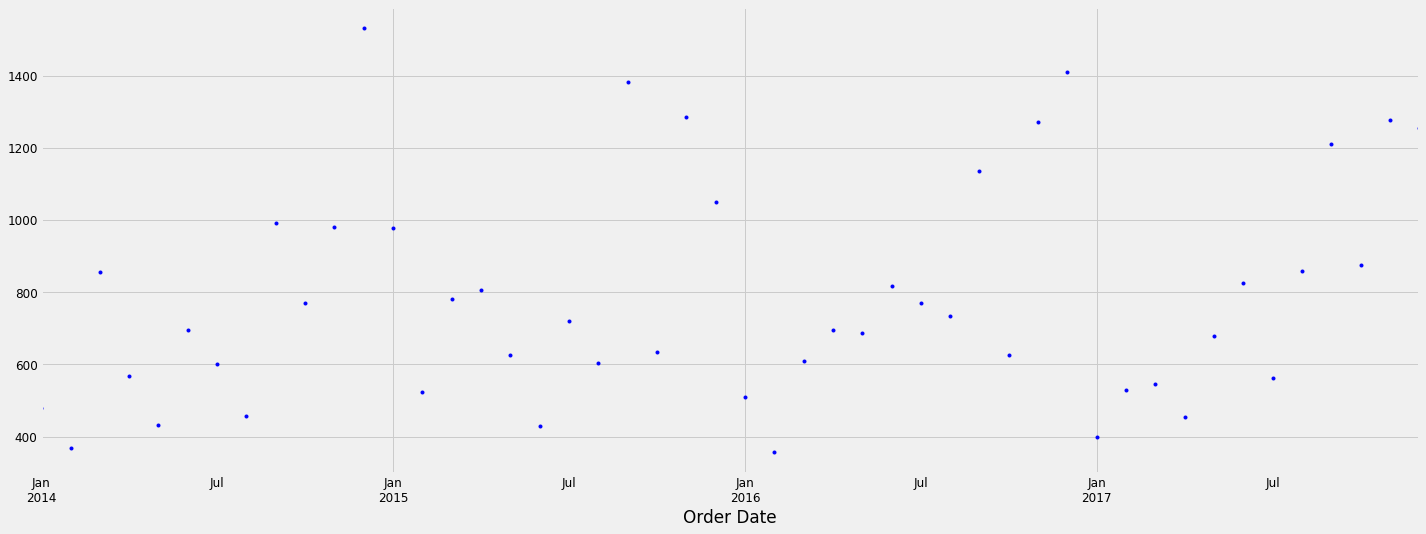

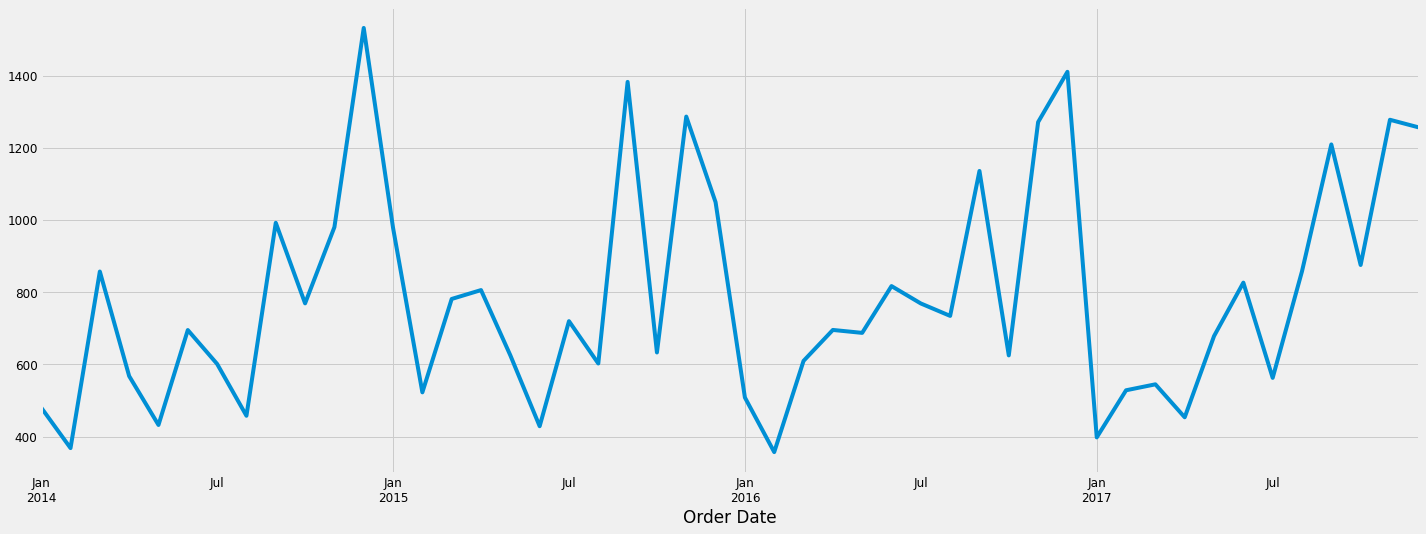

In [24]:
line_plot(furniture, 'dot plot')
line_plot(furniture)

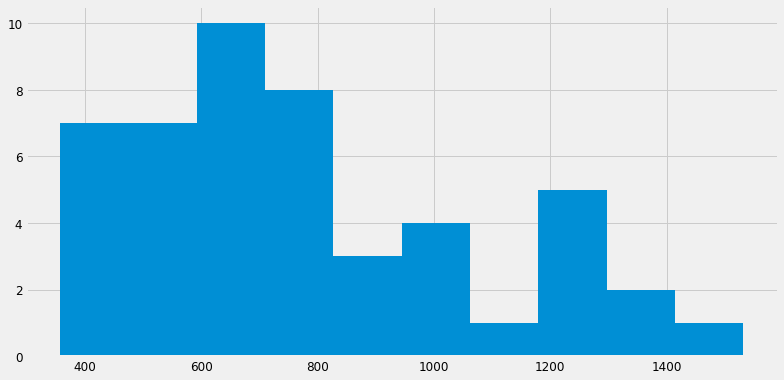

In [25]:
hist_plot(furniture)

We cant appreciate properly if there is a gaussian curve in this histogram. Therefore a density plot might be able to help here. 

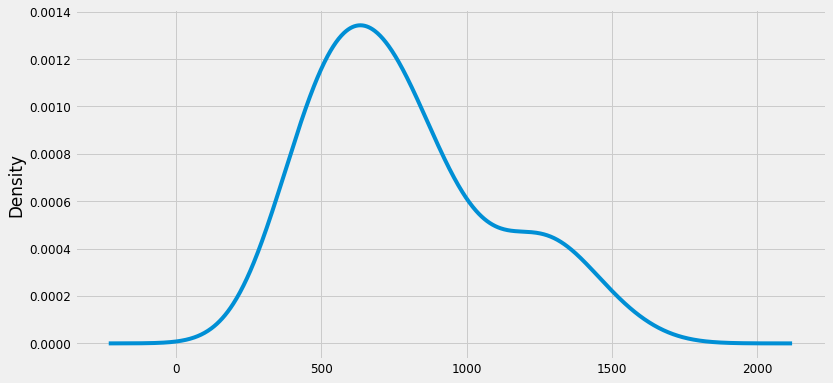

In [26]:
density_plot(furniture)

As expected the density plot shows a more reliable guassian curve. We can say that this data is normally distributed

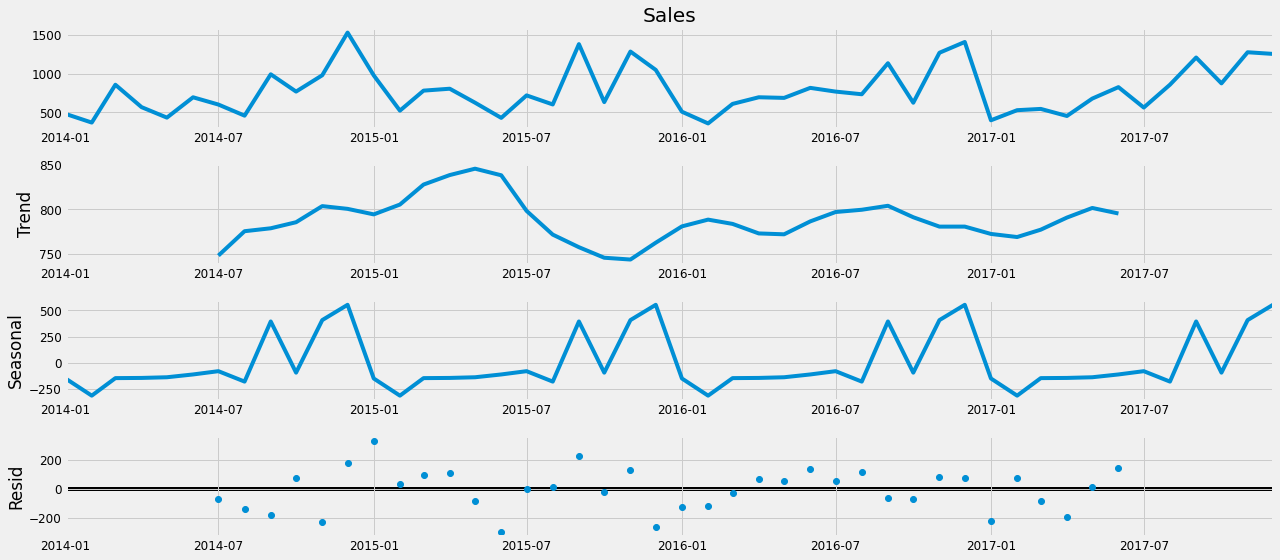

In [27]:
rcParams['figure.figsize']=18,8
decomposition = sm.tsa.seasonal_decompose(furniture, model = 'additive')
fig = decomposition.plot()
plt.show()

It can be appreciated that there is seasonality towards the end of every year as there is an increase in sales. 

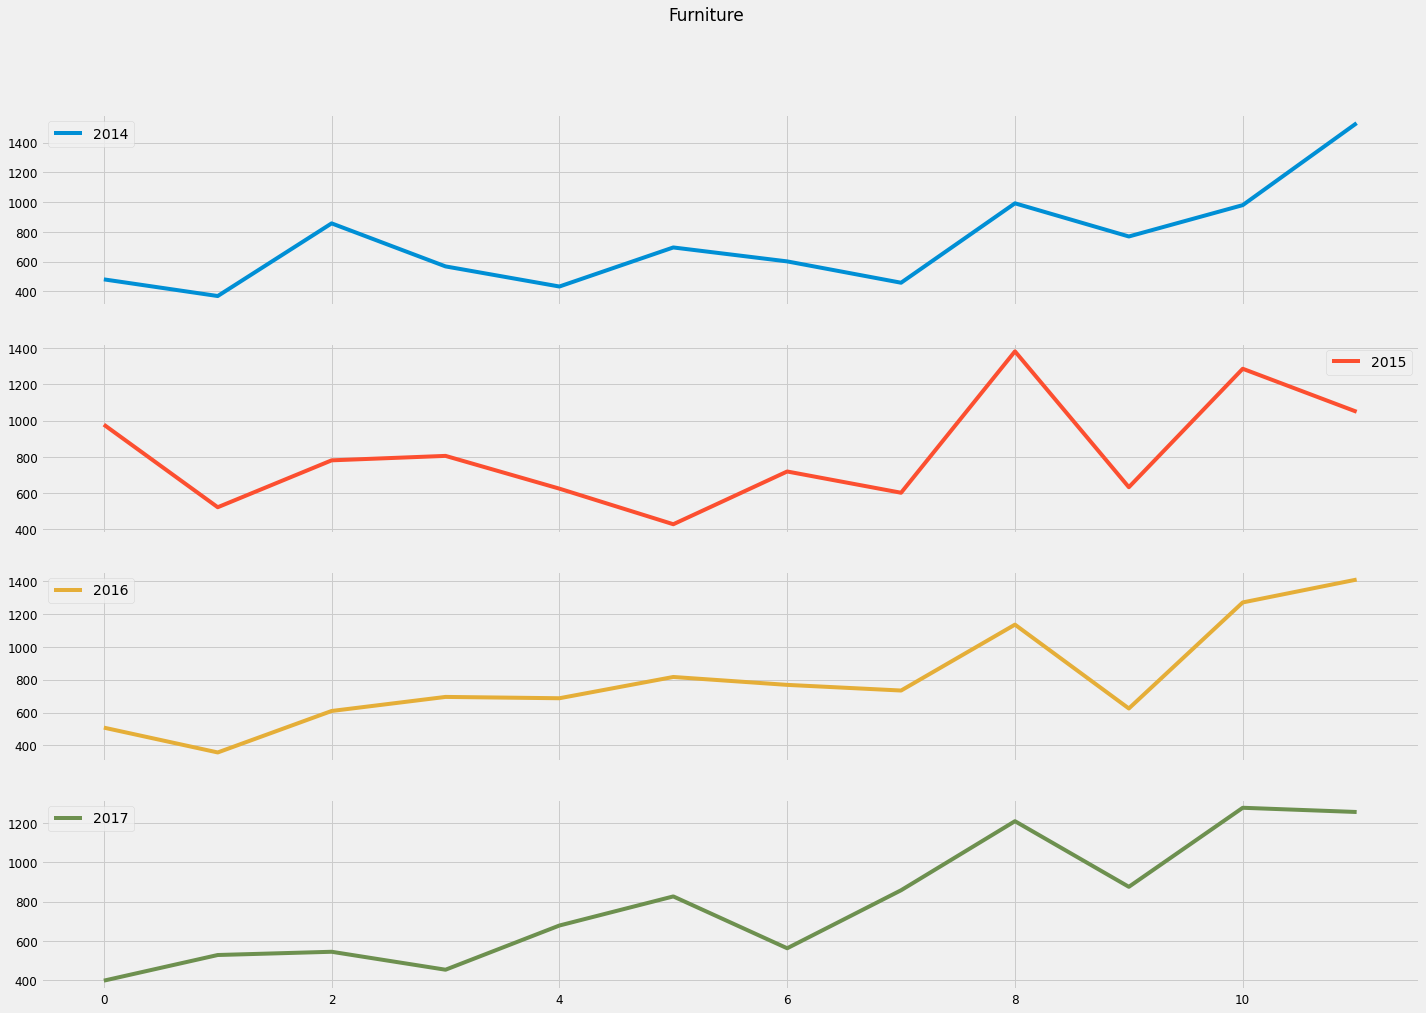

<Figure size 864x432 with 0 Axes>

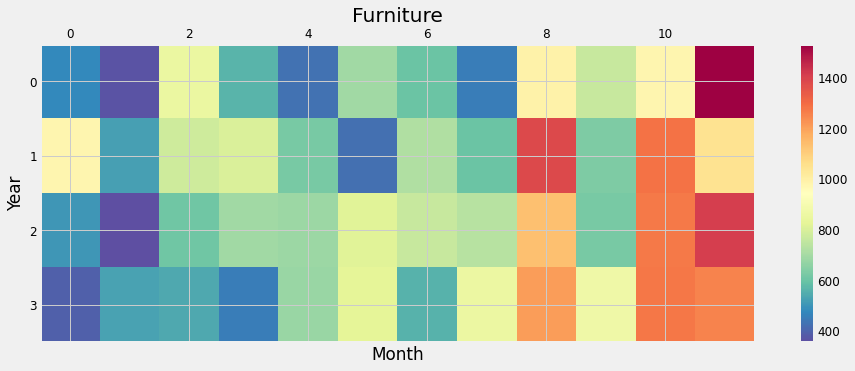

In [28]:
temp_annual = group_data(furniture,'Furniture')
heatmap(temp_annual, 'Furniture')

Heatmap and yearly line plot shows that towards the end of the year the sales increase rapidly, specially from month 10 to 12 (October-December. This corroborates with the 4 year line graph.


## Rolling Statistics

Using Rolling statistics, it can be determined if the data is stationary. The rolling Meand and Standard Deviation need to be constant to determine that the data is stationary

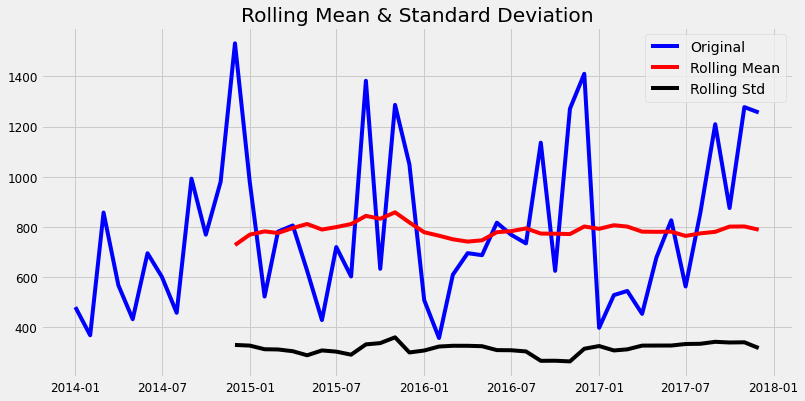

In [29]:
rolling_stats(furniture)

The rolling mean is constant as well as the rolling standard deviation. Therefore, visually the data is stationary. 

## The Dickey-Fuller Test 

Running the Dickey Fuller test will allow to further validate if the data is stationary. The main idea of the Dickey-Fuller test is the null-hypothesis, therefore if the test statistics is less than the 0.5 (p>0.5) then we reject the null hypothesis and say that the series is stationary. 

In [30]:
dickey_fuller(furniture)

Results of Dickey-Fuller test: 

Test Statistic                 -5.191070
p-value                         0.000009
#Lags Used                     10.000000
Number of Observations Used    37.000000
Critical Value (1%)            -3.620918
Critical Value (5%)            -2.943539
Critical Value (10%)           -2.610400
dtype: float64



P-value is less 0.05, therefore the null hypthesis is rejected and the series is stationary. 

 ## Autocorrelation and Partial Autocorrelation

ACF shows the correlation of the time series data with its own lagged values. Lag 1 shows the correlation between the original time series data and one lag1, y_t and y_t-1. The shaded area at the autocorrelation points show weak correlation at those lags, therefore they arent consider significant in the analysis.

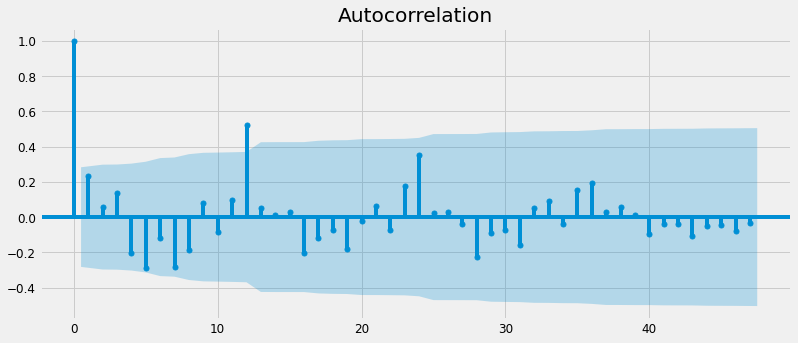

In [31]:
corr(furniture,'ACF')

PACF shows the correlation in a stationary time series data with its own lagged values. However, PACF removes the correlation contribution of other lags, and gives a clean correlation between two lags without the effect of other lags. 

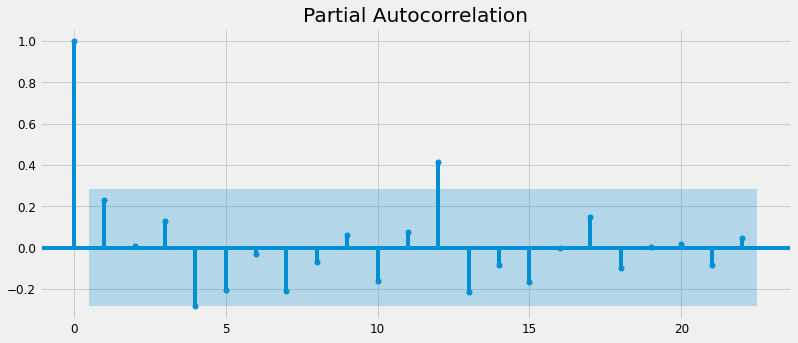

In [32]:
corr(furniture,'PACF')

ACF and PACF is used to determined the correct order for AR(p) and MA(q) components of an ARIMA model. For AR order p, we look at the value of PACF, this value needs to have a significant correlation before correlations become insignificant. 

## ARMA Model 

Now that it has been tested that the data is stationary and that it is also seasonal, as every end of the year the furniture sales go high, It is time to fit the ARIMA Model, However, because it is a seasonal data I have chosen to implement a SARIMAX model 


There's a few things to clarify first, Using autocorrelation and partial autocorrelation I have come to the conclusion of that I am stimating that the values for AR and MA will be between 0 and 1. I will make a gridsearch to find the best possible values for the model using AIC and BIC values as the deciding factor. 

## Splitting the data 

Splitting the data into train and test sets.

In [33]:
furniture.size

48

In [34]:
train = furniture.iloc[:36]
test = furniture.iloc[36:]

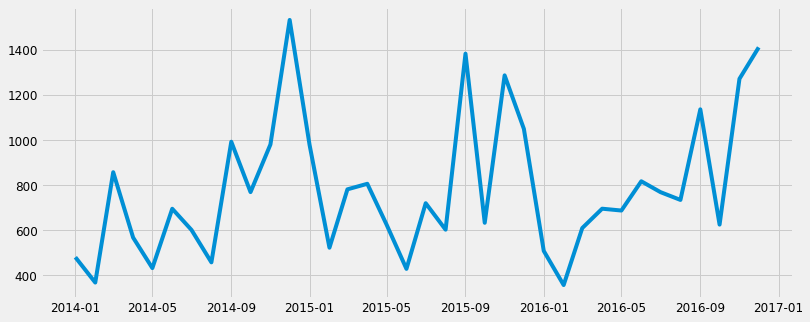

In [35]:
plt.plot(train)

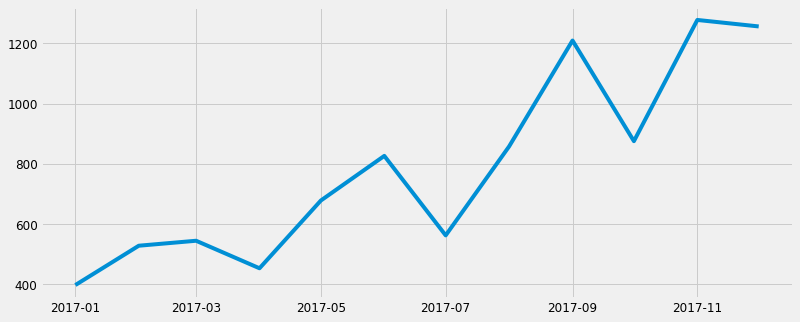

In [36]:
plt.plot(test)

In [37]:
train.head()

Order Date
2014-01-01    480.194231
2014-02-01    367.931600
2014-03-01    857.291529
2014-04-01    567.488357
2014-05-01    432.049188
Freq: MS, Name: Sales, dtype: float64

In [38]:
furniture

Order Date
2014-01-01     480.194231
2014-02-01     367.931600
2014-03-01     857.291529
2014-04-01     567.488357
2014-05-01     432.049188
2014-06-01     695.059242
2014-07-01     601.169500
2014-08-01     457.521656
2014-09-01     992.353367
2014-10-01     769.015437
2014-11-01     980.221486
2014-12-01    1532.298325
2015-01-01     978.328467
2015-02-01     522.395667
2015-03-01     781.236437
2015-04-01     805.822962
2015-05-01     624.996700
2015-06-01     428.565500
2015-07-01     719.706316
2015-08-01     602.412012
2015-09-01    1382.790684
2015-10-01     632.980184
2015-11-01    1286.701354
2015-12-01    1049.355418
2016-01-01     508.182867
2016-02-01     356.868273
2016-03-01     609.575810
2016-04-01     695.373158
2016-05-01     687.265227
2016-06-01     816.910750
2016-07-01     768.736412
2016-08-01     734.307782
2016-09-01    1135.953371
2016-10-01     624.872474
2016-11-01    1271.345152
2016-12-01    1410.719808
2017-01-01     397.602133
2017-02-01     528.179800
2

In [39]:
arima_model =  auto_arima(furniture,start_p=0, d=0, start_q=0, 
                          max_p=3, max_d=2, max_q=3, start_P=0, 
                          D=1, start_Q=0, max_P=3, max_D=2,
                          max_Q=3, m=12, seasonal=True, 
                          error_action='warn',trace = True,
                          supress_warnings=True,stepwise = True )

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=497.083, Time=0.01 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=494.685, Time=0.13 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=0.24 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=495.371, Time=0.01 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=498.718, Time=0.06 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=494.603, Time=0.40 sec
 ARIMA(1,0,0)(3,1,0)[12] intercept   : AIC=inf, Time=1.02 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=0.60 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=0.32 sec
 ARIMA(1,0,0)(3,1,1)[12] intercept   : AIC=inf, Time=1.17 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=492.715, Time=0.31 sec
 ARIMA(0,0,0)(1,1,0)[12] intercept   : AIC=492.740, Time=0.09 sec
 ARIMA(0,0,0)(3,1,0)[12] intercept   : AIC=inf, Time=0.91 sec
 ARIMA(0,0,0)(2,1,1)[12] intercept   : AIC=494.534, Time=0.69 sec
 ARIMA(0,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=0.23

In [40]:
arima_model.aic()

489.8305340037366

The best parameters for the ARIMA model are: p = 0, d=1, q =1 and seasonality 12. 

Time to use de model to predict the data for the next 16 months

In [41]:
prediction = pd.DataFrame(arima_model.predict(n_periods = 12), index=test.index)
prediction.columns = ['sales']
prediction


,sales
Order Date,
2017-01-01,570.832789
2017-02-01,447.093310
2017-03-01,676.301669
2017-04-01,615.484171
2017-05-01,614.152578
2017-06-01,703.658138
2017-07-01,655.642762
2017-08-01,681.722090
2017-09-01,1178.225076


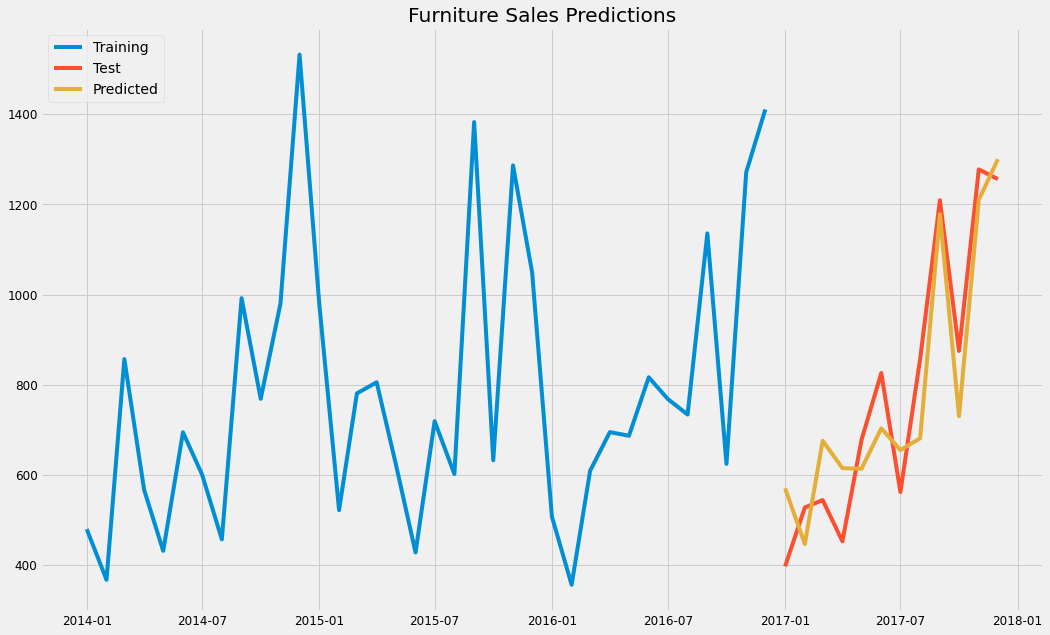

In [42]:
plt.figure(figsize=(16,10))
plt.plot(train, label='Training')
plt.plot(test,label = 'Test')
plt.plot(prediction, label='Predicted')
plt.legend(loc = 'upper left')
plt.title('Furniture Sales Predictions')
plt.show()

In [43]:
prediction['sales']

Order Date
2017-01-01     570.832789
2017-02-01     447.093310
2017-03-01     676.301669
2017-04-01     615.484171
2017-05-01     614.152578
2017-06-01     703.658138
2017-07-01     655.642762
2017-08-01     681.722090
2017-09-01    1178.225076
2017-10-01     730.566250
2017-11-01    1209.933778
2017-12-01    1300.554449
Freq: MS, Name: sales, dtype: float64

In [44]:
sqrt(mean_squared_error(test, prediction['sales']))


118.18940830363664

## Time Series Office Supplies

In [45]:
off_supplies = pre_process_data(df,'Office Supplies', 'Y')

C:\Users\EC\anaconda3\envs\myenv2\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [46]:
off_supplies

,Sales
Order Date,
2014-01-03,16.448
2014-01-04,288.060
2014-01-05,19.536
2014-01-06,685.340
2014-01-07,10.430
...,...
2017-12-26,814.594
2017-12-27,13.248
2017-12-28,1091.244


## Indexing for Time Series Data

In [47]:
off_supplies = off_supplies['Sales'].resample('MS').mean()

In [48]:
off_supplies['2015']

Order Date
2015-01-01    129.198571
2015-02-01    335.504187
2015-03-01    690.545522
2015-04-01    502.342320
2015-05-01    364.549440
2015-06-01    560.407737
2015-07-01    205.214739
2015-08-01    558.814667
2015-09-01    772.230680
2015-10-01    361.392083
2015-11-01    757.790357
2015-12-01    540.055800
Freq: MS, Name: Sales, dtype: float64

##  EDA for Office Supplies Time Series

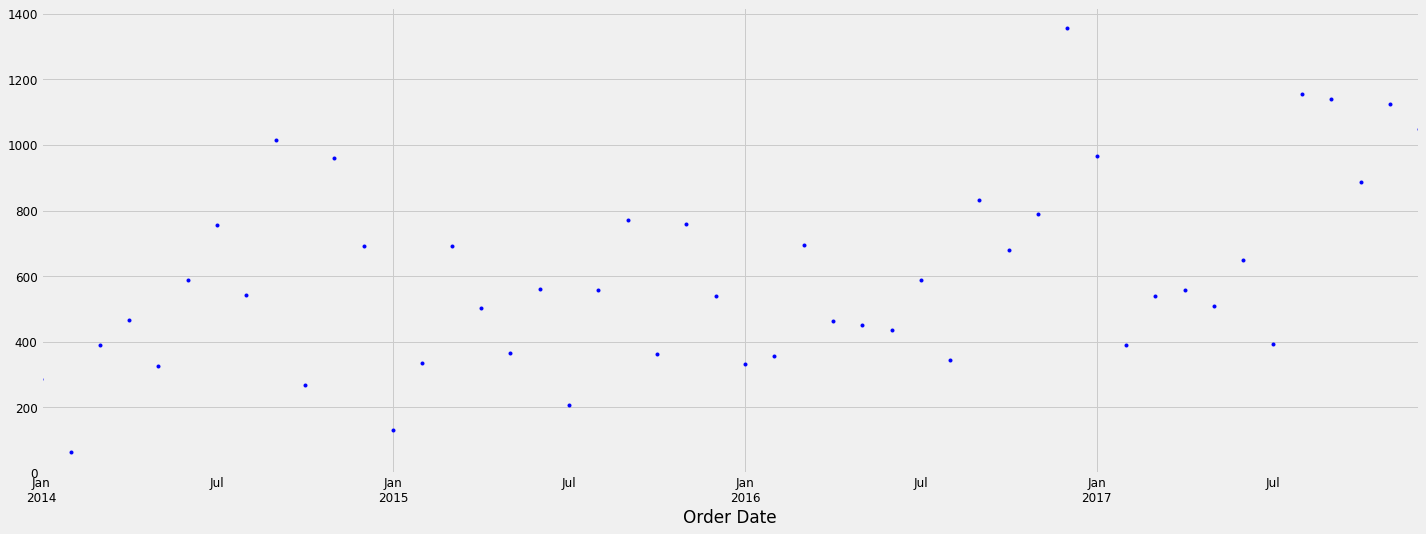

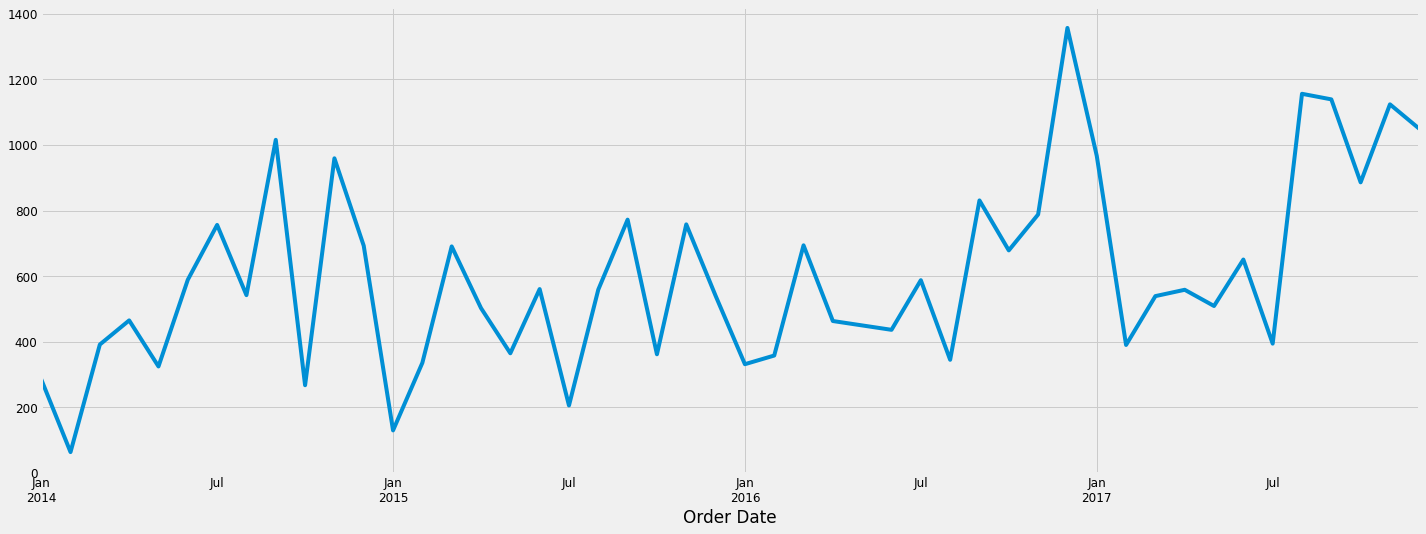

In [49]:
line_plot(off_supplies, 'dot plot')
line_plot(off_supplies)

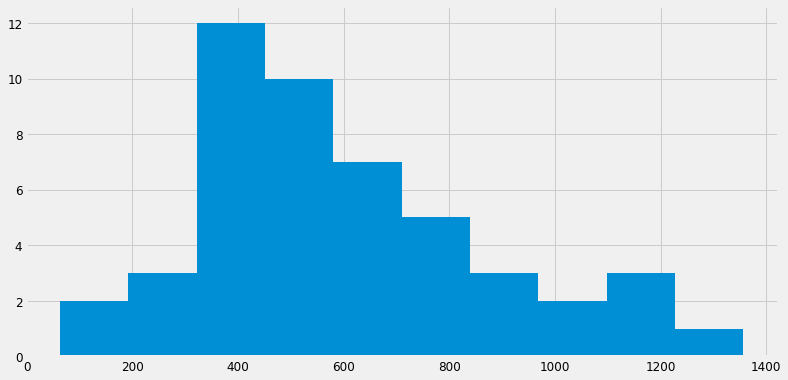

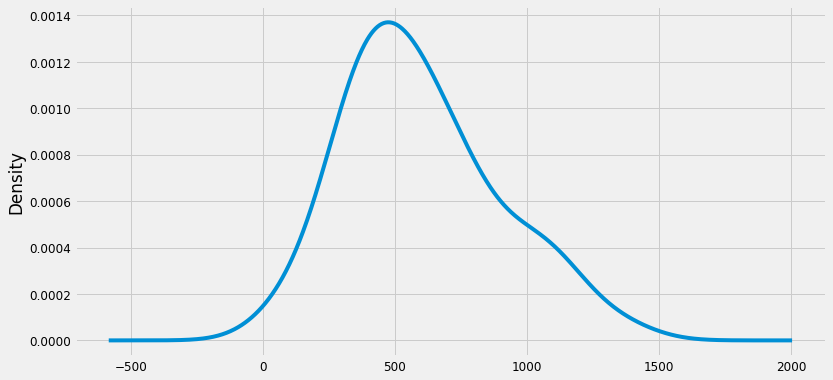

In [50]:
hist_plot(off_supplies)
density_plot(off_supplies)

In the density plot we can see that there is a guassian curve. The histogram also shows it

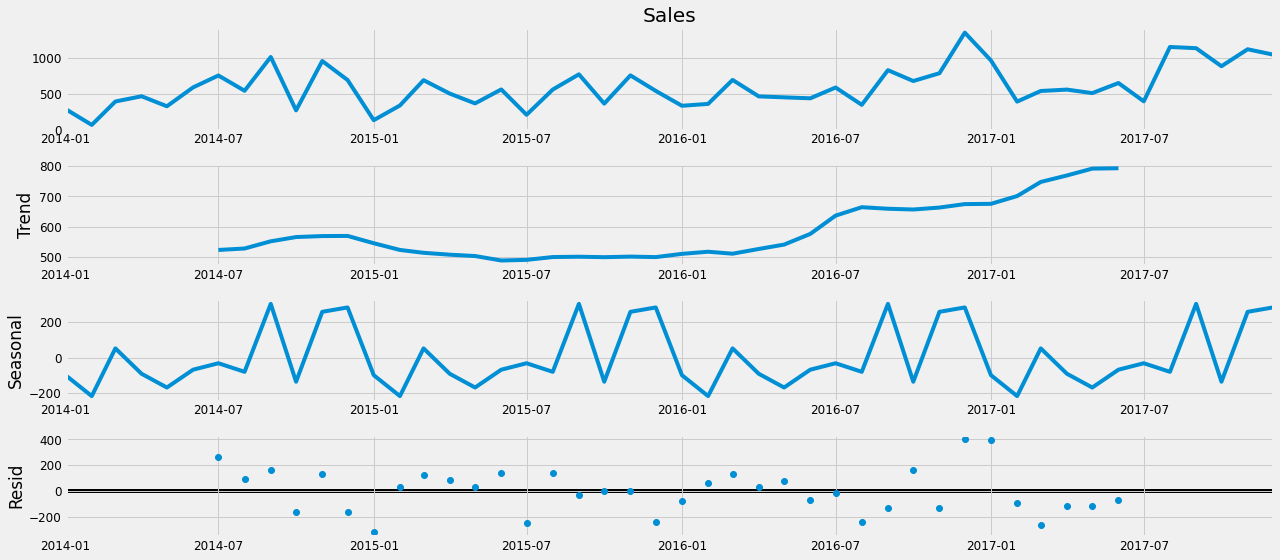

In [51]:
rcParams['figure.figsize']=18,8
decomposition = sm.tsa.seasonal_decompose(off_supplies, model = 'additive')
fig = decomposition.plot()
plt.show()

There is seasonality in the dataset as well. Towards the end of the year and at the beggining. 

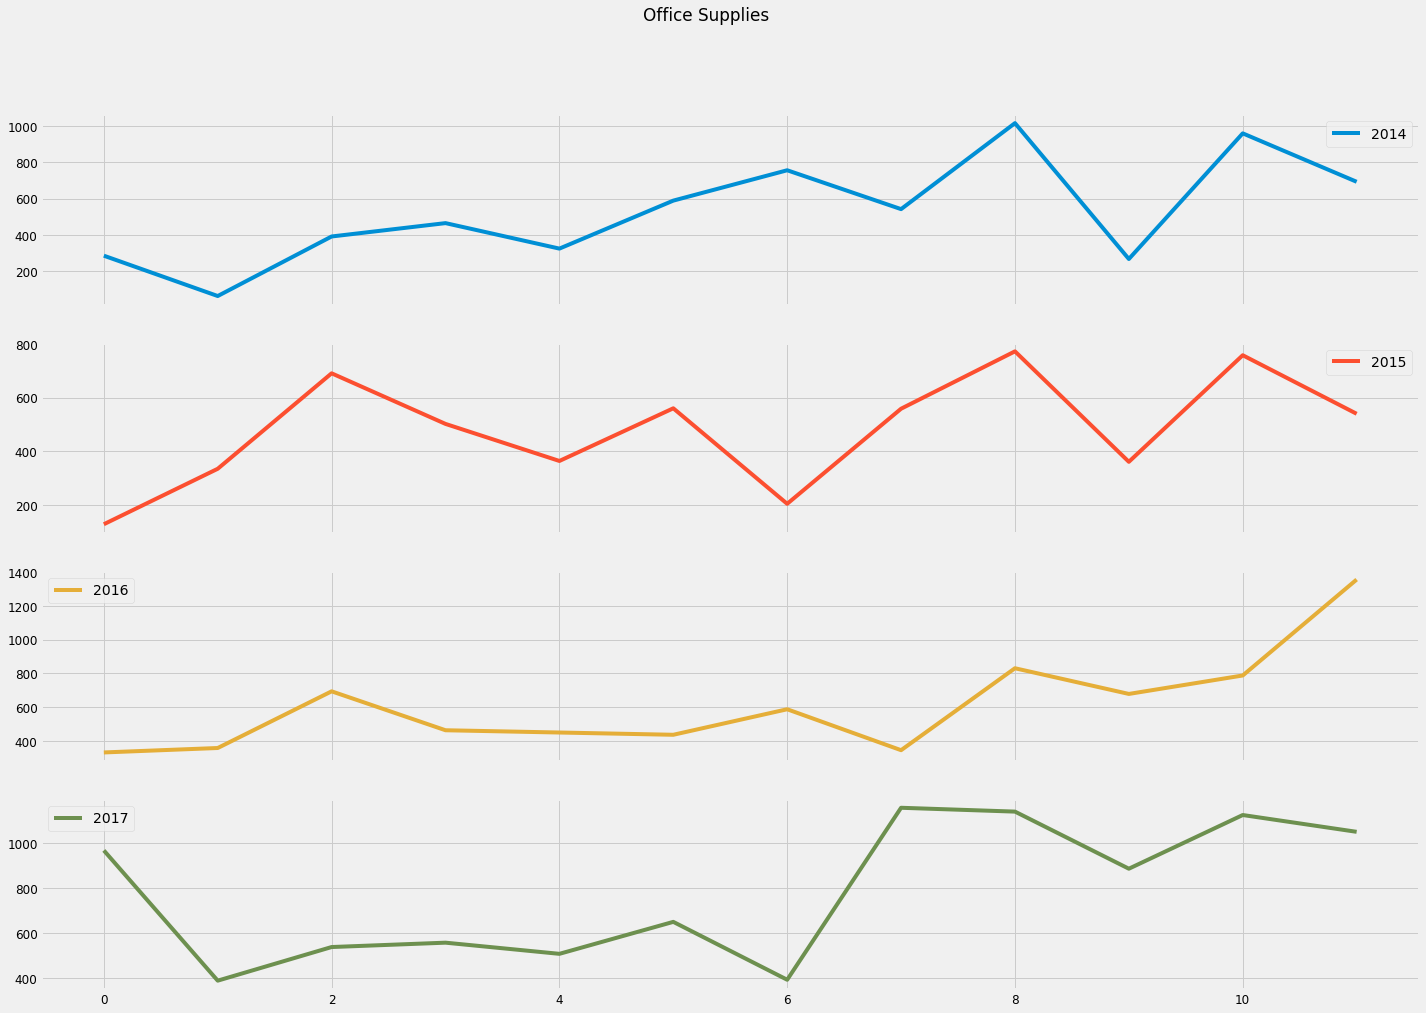

<Figure size 864x432 with 0 Axes>

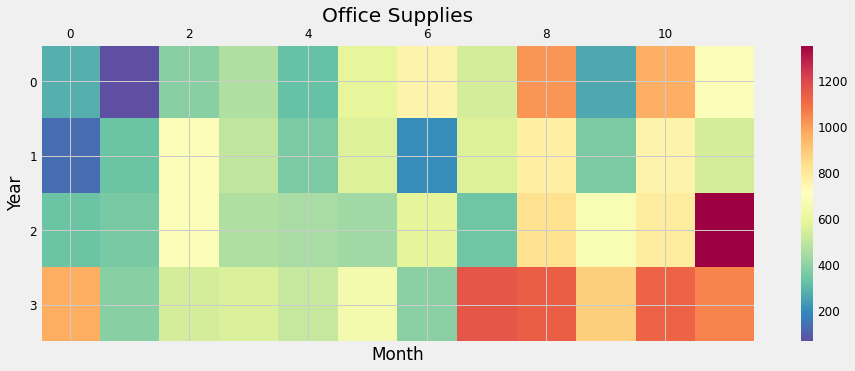

In [52]:
off_sup_annual = group_data(off_supplies, 'Office Supplies')
heatmap(off_sup_annual, 'Office Supplies')

Heatmap shows that Month 8, 10 and 11 are the busiest during the year. 

## Rolling Statistics 

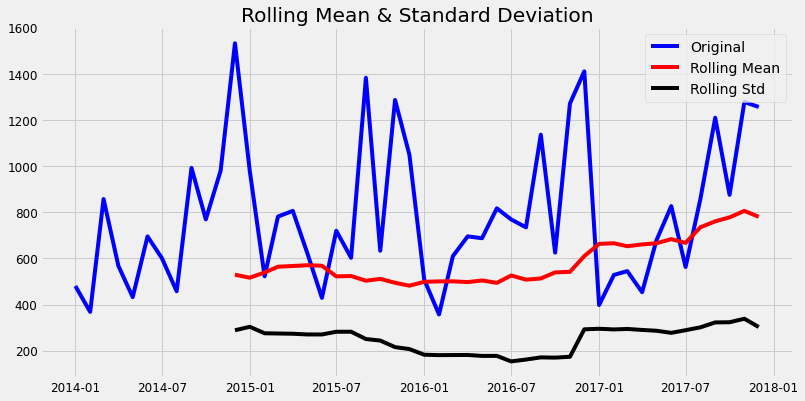

In [53]:
rolling_stats(off_supplies)

The rolling mean and the rolling Standard Deviation are almost constant. Threfore, visually the data could be stationary. Further techniques are needed to emphasize this.

## The Dickey-Fuller Test

It can be deduced that the data is not stationary just by using Rolling Statistics as we need the standard deviation and the mean to be constant. However, it is always safe to check the data using the Dickey-fuller test

In [54]:
dickey_fuller(off_supplies)

Results of Dickey-Fuller test: 

Test Statistic                 -4.664633
p-value                         0.000098
#Lags Used                      0.000000
Number of Observations Used    47.000000
Critical Value (1%)            -3.577848
Critical Value (5%)            -2.925338
Critical Value (10%)           -2.600774
dtype: float64


Same as we did with the Furniture data, we are looking to regect the null hypothesis and say that the data is stationary. However, p-Value is less than 0.05. Therefore, we reject the null Hypothesis and state that the data is stationary

## Autocorrelation and Partial Autocorrelation

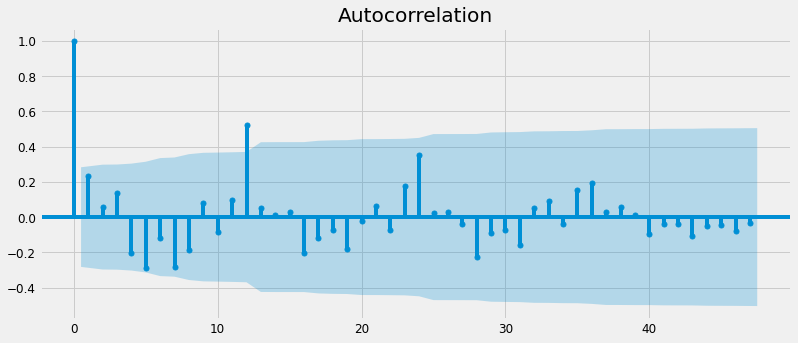

In [55]:
corr(off_supplies,'ACF')

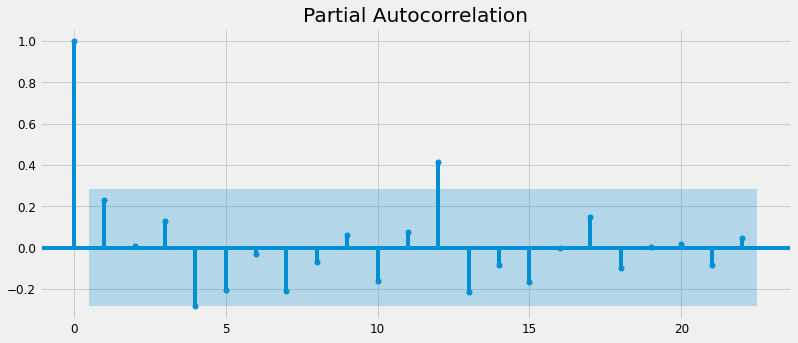

In [56]:
corr(off_supplies,'PACF')

## Splitting the data

In [57]:
train_off_sup = off_supplies.iloc[:36]
test_off_sup = off_supplies.iloc[36:]

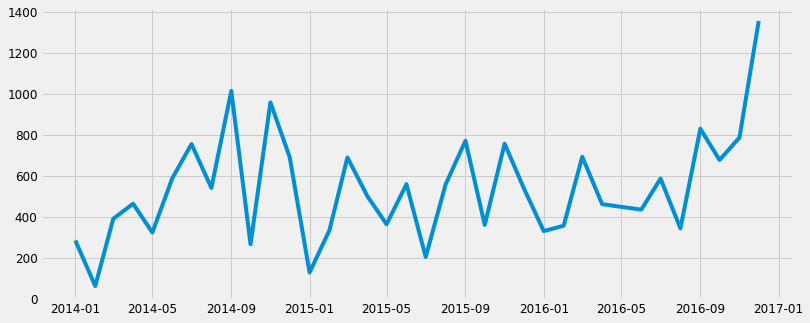

In [58]:
plt.plot(train_off_sup)

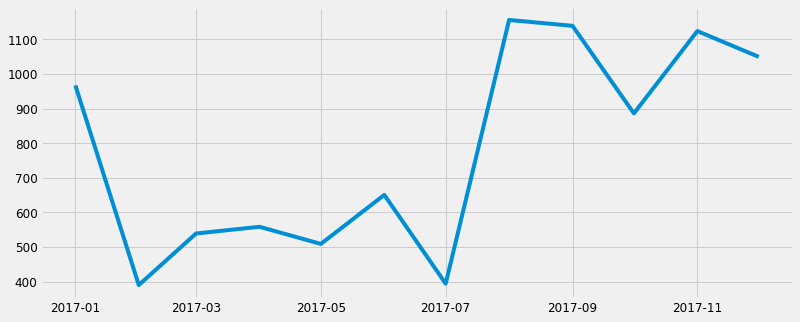

In [59]:
plt.plot(test_off_sup)

In [60]:
off_model =  auto_arima(off_supplies,start_p=0, d=1, start_q=0, 
                          max_p=3, max_d=2, max_q=3, start_P=0, 
                          D=1, start_Q=0, max_P=3, max_D=2,
                          max_Q=3, m=12, seasonal=True, 
                          error_action='warn',trace = True,
                          supress_warnings=True,stepwise = True )

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=518.069, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=503.849, Time=0.08 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.21 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=509.571, Time=0.01 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=503.975, Time=0.31 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=0.31 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=inf, Time=0.19 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=505.789, Time=0.71 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=508.187, Time=0.06 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=502.775, Time=0.12 sec
 ARIMA(2,1,0)(0,1,0)[12]             : AIC=508.273, Time=0.03 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=503.713, Time=0.36 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=503.563, Time=0.27 sec
 ARIMA(2,1,0)(0,1,1)[12]             : AIC=inf, Time=0.31 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, T

In [61]:
off_model.aic()

497.51517766106736

In [62]:
prediction_off_sup = pd.DataFrame(off_model.predict(n_periods = 12), index=test_off_sup.index)
prediction_off_sup.columns = ['sales']
prediction_off_sup

,sales
Order Date,
2017-01-01,885.992233
2017-02-01,618.028420
2017-03-01,862.978434
2017-04-01,754.094763
2017-05-01,723.089570
2017-06-01,785.317778
2017-07-01,737.753119
2017-08-01,985.087057
2017-09-01,1225.888439


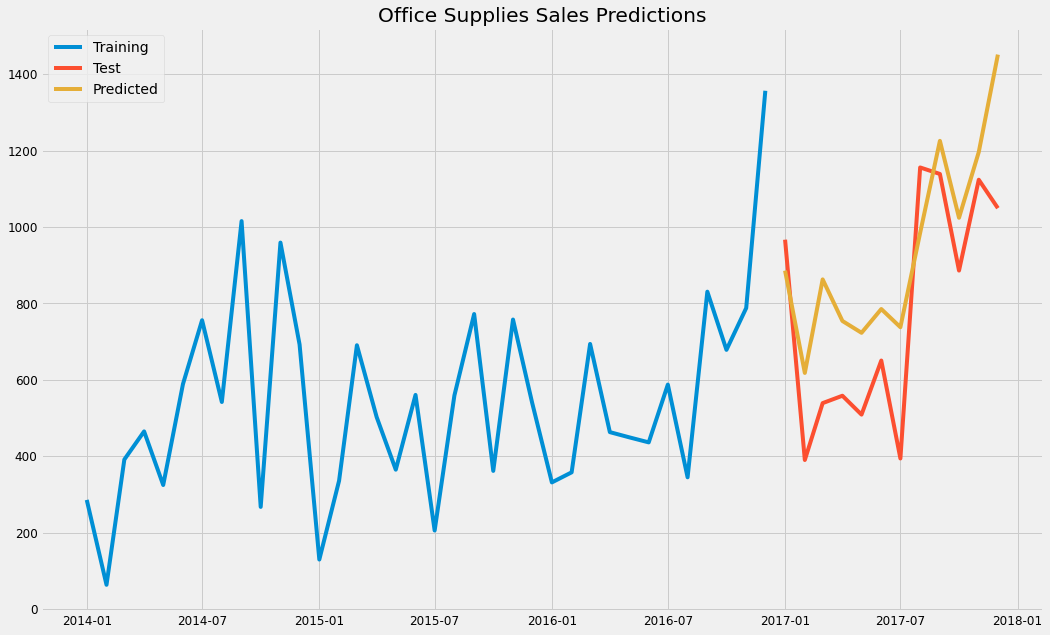

In [63]:
plt.figure(figsize=(16,10))
plt.plot(train_off_sup, label='Training')
plt.plot(test_off_sup,label = 'Test')
plt.plot(prediction_off_sup, label='Predicted')
plt.legend(loc = 'upper left')
plt.title('Office Supplies Sales Predictions')
plt.show()

In [64]:
sqrt(mean_squared_error(test_off_sup, prediction_off_sup['sales']))


224.96545053806332

## Time Series Modelling with FbProphet

### Data Prep

The dataset form fbprophet needs to have two different columns, DS (date) and Y (sales or whatever column we are trying to predict)

In [65]:
furniture = pre_process_data(df, 'Furniture')
office = pre_process_data(df,'Office Supplies')

C:\Users\EC\anaconda3\envs\myenv2\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [66]:
furniture.head()

,ds,y
0,2014-01-01,480.194231
1,2014-02-01,367.931600
2,2014-03-01,857.291529
3,2014-04-01,567.488357
4,2014-05-01,432.049188


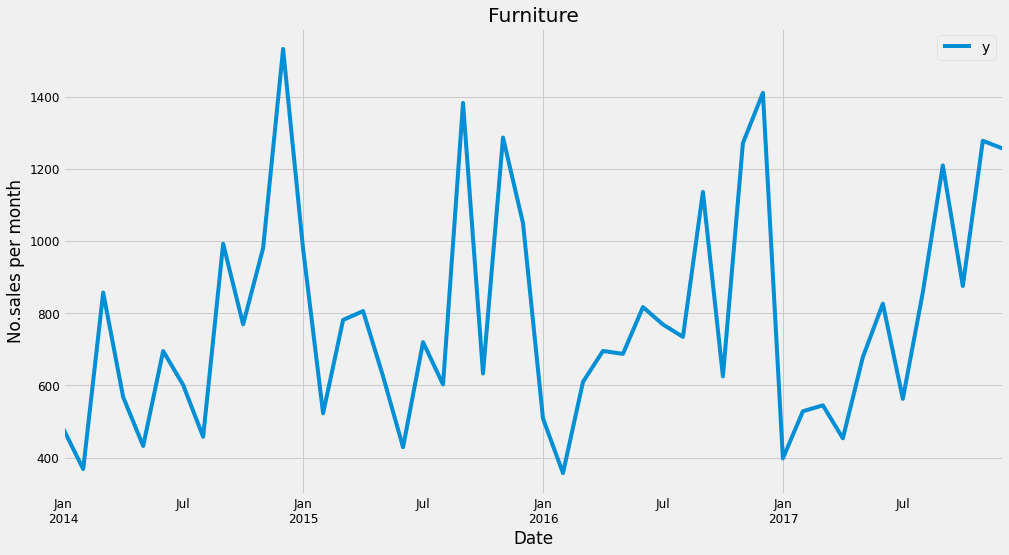

In [67]:
# Plot the timeseries 
pd.plotting.register_matplotlib_converters()
ax = furniture.set_index('ds').plot(figsize=(15, 8))
ax.set_ylabel('No.sales per month')
ax.set_xlabel('Date')
plt.title('Furniture')
plt.show()

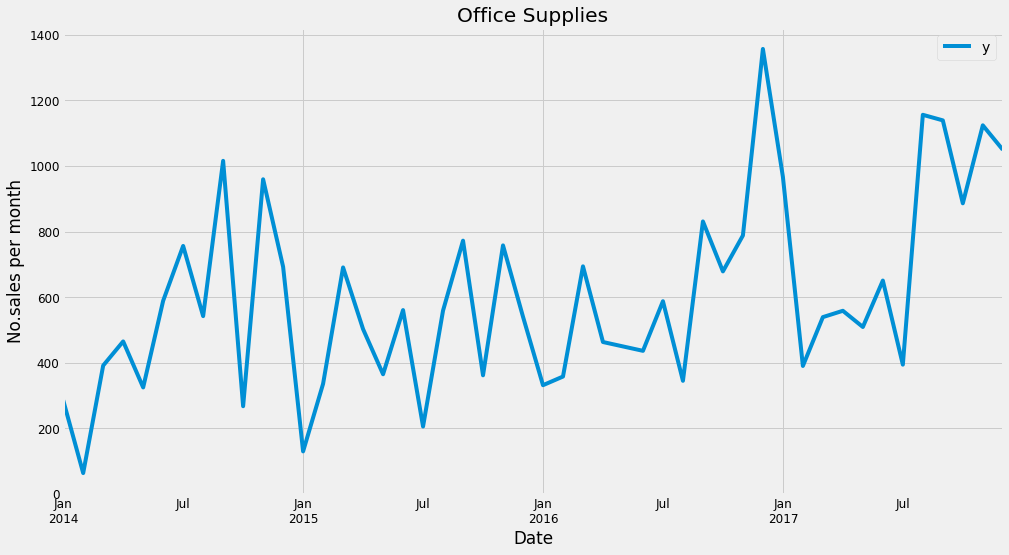

In [68]:
# Plot the timeseries 
pd.plotting.register_matplotlib_converters()
ax = office.set_index('ds').plot(figsize=(15, 8))
ax.set_ylabel('No.sales per month')
ax.set_xlabel('Date')
plt.title('Office Supplies')
plt.show()

### Fit Fbprophet model

In [69]:
furniture_model= Prophet(interval_width=0.95)
office_model = Prophet(interval_width =0.95)

In [70]:
furniture_model.fit(furniture)
office_model.fit(office)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [71]:
furniture_forecast = furniture_model.make_future_dataframe(periods=36, freq='MS')
furniture_forecast = furniture_model.predict(furniture_forecast)
office_forecast = office_model.make_future_dataframe(periods=36, freq='MS')
office_forecast = office_model.predict(office_forecast)

<Figure size 1440x576 with 0 Axes>

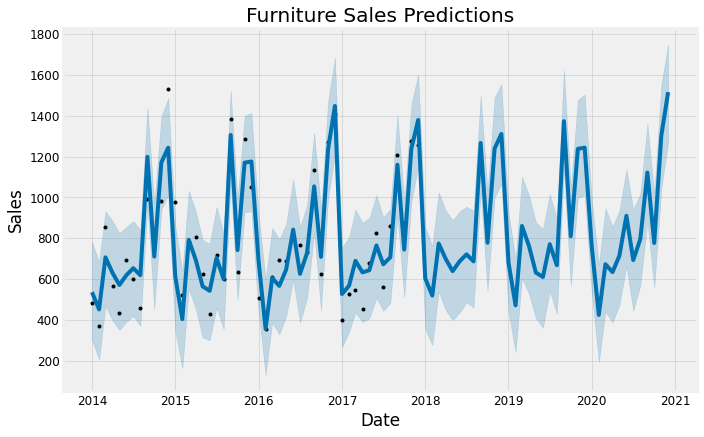

In [72]:
plt.figure(figsize=(20, 8))
furniture_model.plot(furniture_forecast, xlabel = 'Date', ylabel = 'Sales')
plt.title('Furniture Sales Predictions');


<Figure size 1440x576 with 0 Axes>

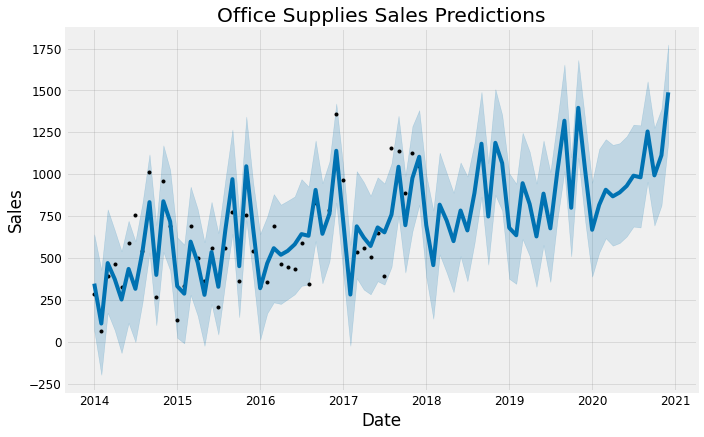

In [73]:
plt.figure(figsize=(20, 8))
office_model.plot(office_forecast, xlabel = 'Date', ylabel = 'Sales')
plt.title('Office Supplies Sales Predictions');


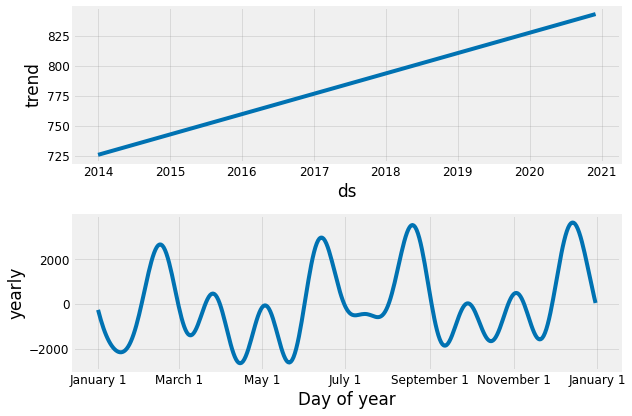

In [74]:
furniture_model.plot_components(furniture_forecast);

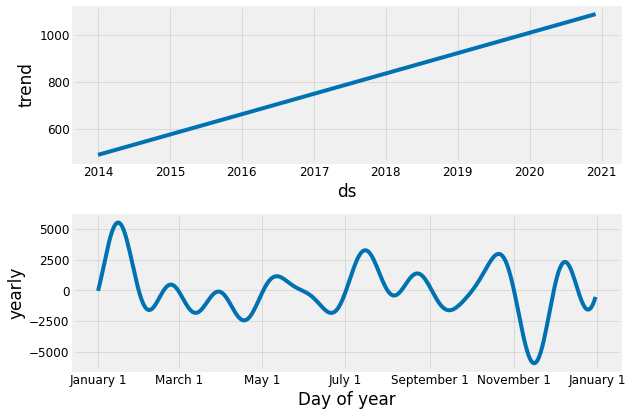

In [75]:
office_model.plot_components(office_forecast);

## Conclussion

The volume of sales per month for both Office Supplies and Furniture, increase steadily over time. However, Office Supplies does trend higher than Furniture.

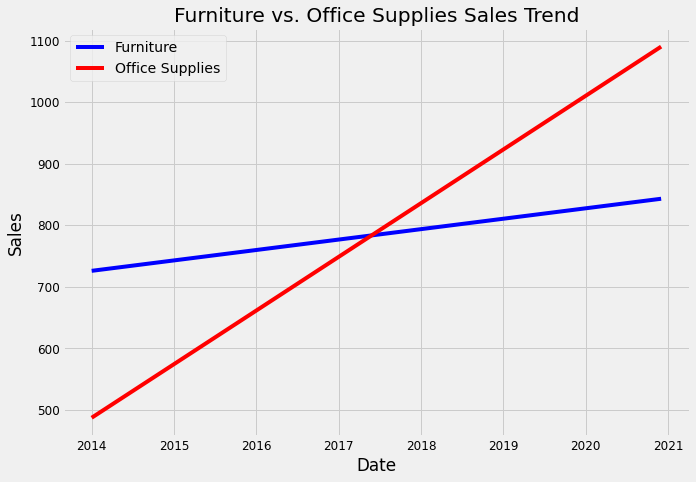

For the office supplies department, during the months of November and December the sales increase dramatically. Therefore, it is recommended:
- To hire more personnel as this will be needed. 
- It is also recommended to have enough stock to maintain a high quality service for every customer that desires to buy Office   Supplies. 
- Sales in Office Supplies increase steadily throughout the years, therefore, maintaining a minmium of employess in this section is recommended

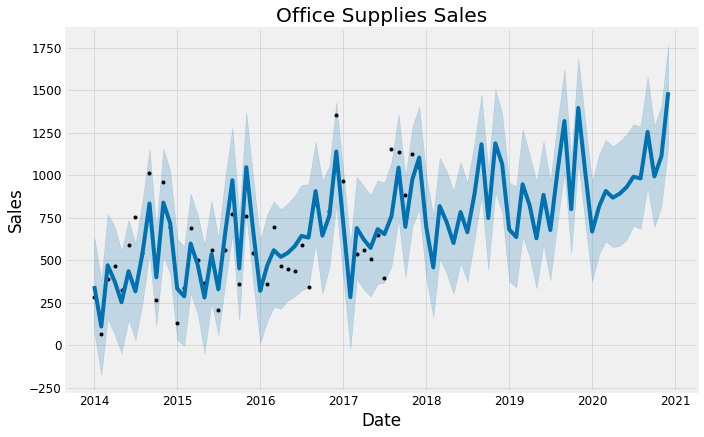

Moving to furniture, August and December are the months where sales spike up dramatically. 
This indicates that: 
- A minimum personnel is to be maintained throughout these months, perhaps even increasing workforce.
- Increasing stock this month is also recommended as sales will increase .
- January to May are quiet months therefore personnel can be redirected to different departments. 


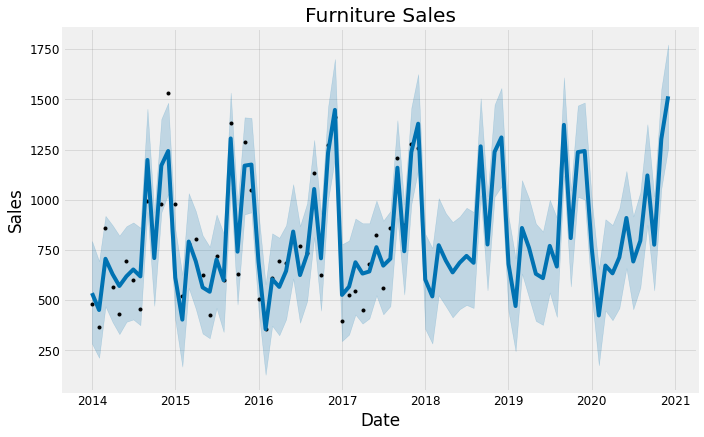

# Appendix 

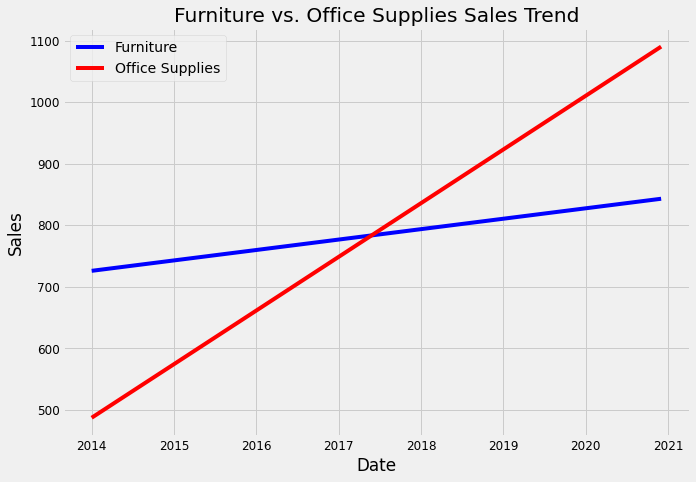

In [76]:
plt.figure(figsize=(10, 7))
furniture_plot, = plt.plot(furniture_forecast['ds'], furniture_forecast['trend'], 'b-')
office_plot, = plt.plot(office_forecast['ds'], office_forecast['trend'], 'r-')
plt.legend([furniture_plot,office_plot],["Furniture","Office Supplies"]); plt.xlabel('Date'); plt.ylabel('Sales')
plt.title('Furniture vs. Office Supplies Sales Trend');

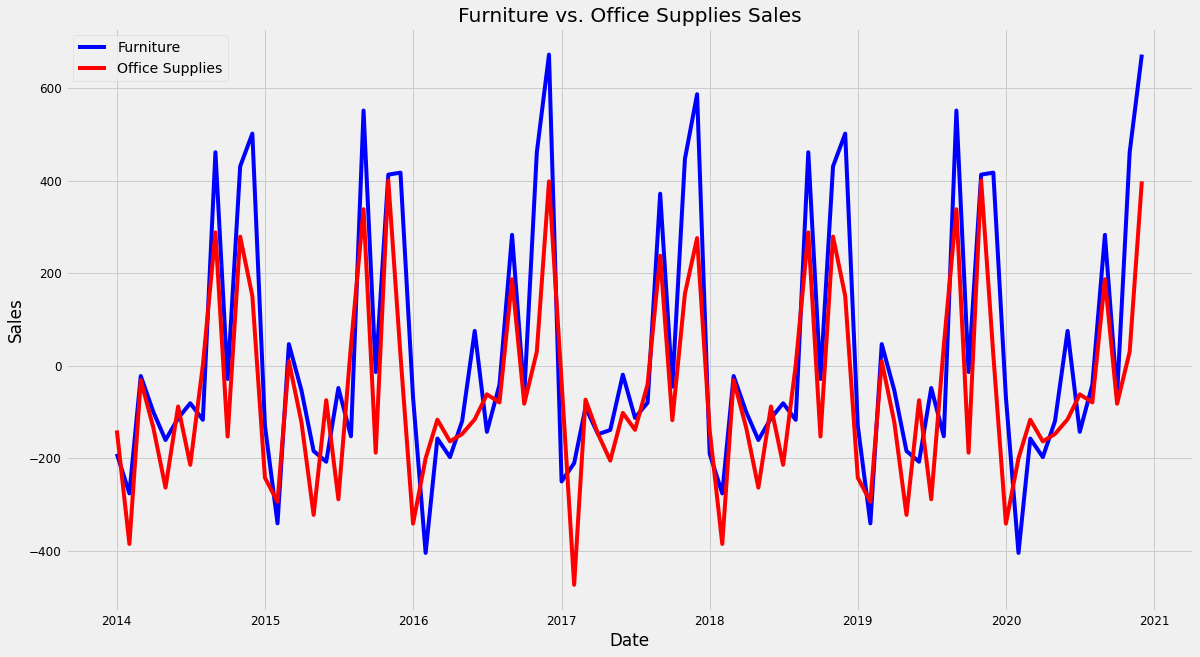

In [77]:
plt.figure(figsize=(18, 10))
furniture_plot, = plt.plot(furniture_forecast['ds'], furniture_forecast['yearly'], 'b-')
office_plot, = plt.plot(office_forecast['ds'], office_forecast['yearly'], 'r-')
plt.legend([furniture_plot,office_plot],["Furniture","Office Supplies"]); plt.xlabel('Date'); plt.ylabel('Sales')
plt.title('Furniture vs. Office Supplies Sales');